In [1]:
import jax
import jax.numpy as jnp
import myjax.nn as nn
import myjax.optim as optim
from myjax.nn.functional import mse_loss
from myjax.utils import random_split, Dataset, DataLoader
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
#%matplotlib widget
plt.style.use('fivethirtyeight')

### Test against problems from Chap. 3 of D2L

#### Problem 3.3

In [2]:
#def mse_loss(input, target):
#    return jnp.mean((input-target)**2)


class MyModel(nn.Model):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential([nn.Linear(2,1) ])

    def training_step(self, params, batch):
        # MSE Loss
        x, y = batch
        # print (params)
        y_hat = self.model(params, x)
        loss = mse_loss(y_hat, y)
        return loss
        
    def validation_step(self, params, batch):
        # MSE Loss
        x, y = batch
        y_hat = self.model(params, x)
        loss = mse_loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        sgd = optim.SGD(learning_rate=0.03, weight_decay=0.01)
        return sgd


The model is: 
Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True), Total parameters: 3, 
)
Total parameters: 3

The initial parameters are: 
{0: {'weights': Array([[ 0.4065961],
       [-1.2013793]], dtype=float32), 'bias': Array([-0.02575834], dtype=float32)}}

Epoch (    0/    4) train_loss = 10.852
Epoch (    1/    4) train_loss = 0.70299, val_loss = 0.51297
Epoch (    2/    4) train_loss = 0.02784, val_loss = 0.02664
Epoch (    3/    4) train_loss = 0.01031, val_loss = 0.01255
Epoch (    4/    4) train_loss = 0.00817, val_loss = 0.01149

The final parameters are (with w = [ 2.  -3.4] and b = 4.2 as correct answer): 
{0: {'bias': Array([4.1764874], dtype=float32), 'weights': Array([[ 1.9849694],
       [-3.3771694]], dtype=float32)}}
error in estimating w: [ 0.01503062 -0.02283072]
error in estimating b: [0.02351236]


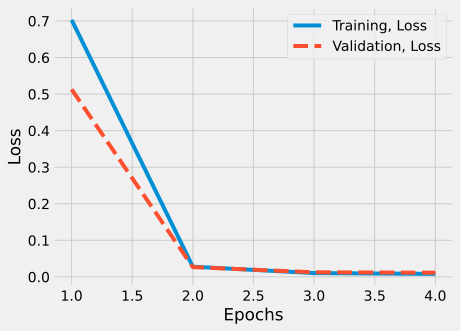

In [5]:
# Random data for testing
seed = 1701
key = jax.random.PRNGKey(seed)
key, x_key, n_key = jax.random.split(key, num=3)

# Create synthetic data
num_train=1000
num_val=1000
w = jnp.array([2, -3.4])
b = 4.2
n = num_train + num_val
noise = 0.1
noise = jax.random.normal(n_key, shape=(n,1))*noise

X = jax.random.normal(x_key, (n, len(w)))
y = X @ w.reshape(-1, 1) + b + noise


# Create dataset
dataset = Dataset(X, y)
train_dataset, val_dataset = random_split(dataset, train_length=num_train, key=key)

# Create dataloader
train_data = DataLoader(train_dataset, key=key, batch_size=32)
val_data = DataLoader(val_dataset, key=key, batch_size=len(val_dataset))


# Create model
mymodel = MyModel()

# Initialize Model
key, l1_key = jax.random.split(key)
key, params = mymodel.init(key)
print ('\nThe model is: ')
print (mymodel)


# Initialize trainer
trainer = nn.Trainer(max_epochs = 4)
print ('\nThe initial parameters are: ')
print (params)


# Fit model
params = trainer.fit(params, mymodel, train_data, val_data, log_epoch=1, plots=True)
print (f'\nThe final parameters are (with w = {w} and b = {b} as correct answer): ')
print (params)

answ = w - params[0]['weights'].reshape(w.shape)
ansb = b - params[0]['bias']
print(f'error in estimating w: {answ}')
print(f'error in estimating b: {ansb}')



In [19]:
x, y = val_data[0]

In [20]:
x

Array([ 0.59308136, -1.7156556 ], dtype=float32)

In [21]:
y

Array([11.215828], dtype=float32)

In [6]:
print (dataset[:2])
print (train_data[:2])
print (len(dataset))
print (len(train_data))
print (len(val_data))
print (len(train_data) + len(val_data))

(Array([[-0.7962566, -0.8617917],
       [ 2.388094 ,  1.8874515]], dtype=float32), Array([[5.5819483],
       [2.4739218]], dtype=float32))
(Array([[-1.1526136 , -0.37734157],
       [ 1.6678538 , -0.33502012]], dtype=float32), Array([[3.253182],
       [8.719943]], dtype=float32))
2000
32
32
64
